In [7]:
%matplotlib inline

import importlib


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlalchemy

import common
importlib.reload(common)

from common import create_engine
from common import display_all
from common import figsize
from common import save_df


from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() # converters e.g. for datetime in plots

In [8]:
engine = create_engine('db-conf.json', 'local')
pd.sql = lambda sql: pd.read_sql(sqlalchemy.text(sql), con=engine)

Vytvorenie materialized views kvoli obmedzeniu datovej mnoziny

In [11]:
REFRESH_MVIEWS = False

In [10]:
mviews_queries = [
    # iba clanky z monitorov v kategoriach 'english' a 'medical' + publikovane po 'zaciatok-monitoringu' - 4 dni
    '''
    DROP MATERIALIZED VIEW IF EXISTS news_articles CASCADE;
    CREATE MATERIALIZED VIEW new_articles AS (
    SELECT *
    FROM article
    WHERE monitor_id in (1, 4, 5, 7, 8, 9, 10)
      AND published_at >= '2019-10-10 00:00:00.000000');
    ''',
    
    # maximalne id pozorovania pre danu kombinaciu (url, datum)
    '''
    DROP MATERIALIZED VIEW IF EXISTS article_fb_engagement_per_day CASCADE;
    CREATE MATERIALIZED VIEW article_fb_engagement_per_day AS (
    SELECT max(id) last_id_on_day, related_object_url as url, extracted_at::date as sync_on_day
    FROM feedback_facebook
    GROUP BY url, sync_on_day);
    ''',
    
    # fb popularita + url + rozdiel medzi datumom publikovania a datumom ziskania dat z FB
    '''
    DROP MATERIALIZED VIEW IF EXISTS new_articles_fb_engagement CASCADE;
    CREATE MATERIALIZED VIEW new_articles_fb_engagement AS (
    SELECT fb.id,
           fb.related_object_url                     as url,
           fb.reaction_count,
           fb.comment_count,
           fb.share_count,
           fb.comment_plugin_count,
           afepd.sync_on_day,
           na.published_at,
           afepd.sync_on_day - na.published_at::date as days_after_publication
    FROM article_fb_engagement_per_day afepd
             JOIN feedback_facebook fb ON fb.id = afepd.last_id_on_day
             JOIN new_articles na ON na.url = afepd.url);
    '''
]

if REFRESH_MVIEWS:
    with engine.connect() as connection:
        for q in mviews_queries:
            connection.execute(q)

In [168]:
# - obsah clanku (+meta)
# - meno autora
# - pocet obrazkov / videii
# - pocet claimov
# - veracity (podla claimov)
# - zdroj (nazov, url)
# - anotacia doveryhodnosti zdroja

df = pd.sql('''
SELECT a.id,
       a.url,
       title,
       perex,
       body,
       a.published_at,
       extracted_at,
       a.source_id,
       category,
       other_info,
       coalesce(imgc.cnt, 0)                          as image_count,
       coalesce(vidc.cnt, 0)                          as video_count,
       av.veracity,
       av.claims_false,
       av.claims_mixture,
       av.claims_mostly_false,
       av.claims_mostly_true,
       av.claims_true,
       av.claims_unknown,
       aut.name                                       as author_name,
       s.id                                           as source_id,
       s.name                                         as source_name,
       s.url                                          as source_url,
       stype                                          as source_type,
       is_reliable::integer                           as source_is_reliable
FROM new_articles a
         JOIN source s on a.source_id = s.id
         JOIN author aut on a.author_id = aut.id
         LEFT JOIN (SELECT article_id, count(*) as cnt FROM media WHERE media_type = 'image' GROUP BY article_id) imgc
                   ON a.id = imgc.article_id
         LEFT JOIN (SELECT article_id, count(*) as cnt FROM media WHERE media_type = 'video' GROUP BY article_id) vidc
                   ON a.id = vidc.article_id
         JOIN article_veracity av on a.id = av.article_id
WHERE s.is_reliable IS NOT NULL;
''')

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3932 entries, 0 to 3931
Data columns (total 25 columns):
id                     3932 non-null int64
url                    3932 non-null object
title                  3932 non-null object
perex                  2927 non-null object
body                   3927 non-null object
published_at           3932 non-null datetime64[ns]
extracted_at           3932 non-null datetime64[ns]
source_id              3932 non-null int64
category               2309 non-null object
other_info             3930 non-null object
image_count            3932 non-null int64
video_count            3932 non-null int64
veracity               3932 non-null object
claims_false           3932 non-null int64
claims_mixture         3932 non-null int64
claims_mostly_false    3932 non-null int64
claims_mostly_true     3932 non-null int64
claims_true            3932 non-null int64
claims_unknown         3932 non-null int64
author_name            3932 non-null object
source_

In [162]:
# url, popularita na fb, rozdiel sync - publikovanie (max 30 dni)

DAYS_AFTER_POP_CUTOUT = 15

fb = pd.sql(f'''
SELECT url,
       reaction_count,
       share_count,
       comment_count,
       comment_plugin_count,
       sync_on_day,
       days_after_publication
FROM new_articles_fb_engagement
WHERE days_after_publication BETWEEN 0 AND {DAYS_AFTER_POP_CUTOUT};
''')

In [163]:
assert DAYS_AFTER_POP_CUTOUT >= fb.days_after_publication.max()

In [164]:
fb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275847 entries, 0 to 275846
Data columns (total 7 columns):
url                       275847 non-null object
reaction_count            275847 non-null int64
share_count               275847 non-null int64
comment_count             275847 non-null int64
comment_plugin_count      275847 non-null int64
sync_on_day               275847 non-null object
days_after_publication    275847 non-null int64
dtypes: int64(5), object(2)
memory usage: 14.7+ MB


In [165]:
def append_popularity_columns(df, fb):
    df = df.copy()
    fb = fb.copy()
    
    cols = [
        'url',
        'days_after_publication',
        'reaction_count',
        'share_count',
        'comment_count'
    ] 
    
    fb = fb[cols].pivot_table(index='url',
                         columns='days_after_publication')
    fb.columns = [f'fb_ad_{j}_{i}' for i,j in fb.columns.values]

    df = pd.concat((df.set_index('url'), fb), axis=1, join='inner')
    return df.set_index('id')

In [169]:
def append_fb_pop_sum(df):
    df = df.copy()
    for i in range(0, DAYS_AFTER_POP_CUTOUT + 1):
        cols = [
            f'fb_ad_{i}_comment_count',
            f'fb_ad_{i}_share_count',
            f'fb_ad_{i}_reaction_count'
        ]
        df[f'fb_popularity_ad_{i}'] = df[cols].apply(np.sum, axis=1)
        print(df[f'fb_popularity_ad_{i}'].describe())
    return df

In [170]:
xdf = append_popularity_columns(df, fb)
xdf = append_fb_pop_sum(xdf)

df = xdf

count      3590.000000
mean         88.519220
std        2003.452489
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max      114023.000000
Name: fb_popularity_ad_0, dtype: float64
count      3590.000000
mean        456.911699
std        6906.179127
min           0.000000
25%           0.000000
50%           0.000000
75%          62.750000
max      324687.000000
Name: fb_popularity_ad_1, dtype: float64
count      3590.000000
mean        687.403343
std        9686.332035
min           0.000000
25%           0.000000
50%           0.000000
75%         118.500000
max      447072.000000
Name: fb_popularity_ad_2, dtype: float64
count      3590.000000
mean        879.268802
std       12636.031674
min           0.000000
25%           0.000000
50%           2.000000
75%         172.500000
max      599576.000000
Name: fb_popularity_ad_3, dtype: float64
count      3590.000000
mean       1032.102507
std       15613.401229
min           0.000000
25%     

In [151]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3590 entries, 428781 to 804137
Data columns (total 87 columns):
title                      3590 non-null object
perex                      2754 non-null object
body                       3585 non-null object
published_at               3590 non-null datetime64[ns]
extracted_at               3590 non-null datetime64[ns]
source_id                  3590 non-null int64
category                   2149 non-null object
other_info                 3588 non-null object
image_count                3590 non-null int64
video_count                3590 non-null int64
veracity                   3590 non-null object
claims_false               3590 non-null int64
claims_mixture             3590 non-null int64
claims_mostly_false        3590 non-null int64
claims_mostly_true         3590 non-null int64
claims_true                3590 non-null int64
claims_unknown             3590 non-null int64
author_name                3590 non-null object
source_id      

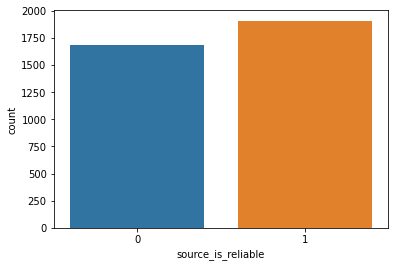

In [152]:
sns.countplot(x='source_is_reliable', data=df)

In [153]:
for i in range(0, DAYS_AFTER_POP_CUTOUT + 1):
    count = len(df[df[f'fb_ad_{i}_comment_count'].notna()])
    print(f'after {i} days: {count} fb observations')

after 0 days: 1259 fb observations
after 1 days: 2108 fb observations
after 2 days: 2362 fb observations
after 3 days: 2552 fb observations
after 4 days: 2727 fb observations
after 5 days: 2747 fb observations
after 6 days: 2809 fb observations
after 7 days: 2866 fb observations
after 8 days: 2906 fb observations
after 9 days: 2967 fb observations
after 10 days: 3045 fb observations
after 11 days: 3115 fb observations
after 12 days: 3129 fb observations
after 13 days: 3134 fb observations
after 14 days: 3137 fb observations
after 15 days: 3167 fb observations


In [154]:
def cell(n_days=7, n_obs=3): 
    rr_fb_cc = df[[f'fb_ad_{i}_comment_count' for i in range(0, n_days + 1)]]
    rr_fb_cc = rr_fb_cc.apply(lambda x: pd.isna(x).sum(), axis=1)

    print(f'at least {n_obs} observations in first {n_days} days: {(rr_fb_cc >= n_obs).sum()}')
    
cell(5, 3)

at least 3 observations in first 5 days: 1274


In [155]:
claim_cols = [cn for cn in df.columns if cn.startswith('claims_')]
df_cc = df[claim_cols]
avg_claim_count = df_cc.apply(sum, axis=1).mean()
rows_with_zero_claims = len(df) - (df[claim_cols].apply(sum, axis=1) > 0).sum()

print(f'avg_claim_count == {avg_claim_count}')
print(f'rows_with_zero_claims == {rows_with_zero_claims}')

avg_claim_count == 2.866573816155989
rows_with_zero_claims == 0


SyntaxError: invalid syntax (<ipython-input-156-919a52495825>, line 4)

In [177]:
df.source_name.value_counts()

naturalnews.com                  608
medicinenet.com                  410
neurosciencenews.com             235
medicaldaily.com                 228
statnews.com                     173
webmd.com                        153
medicalnewstoday.com             136
healthnutnews.com                134
foxnews.com                      113
healthcentral.com                103
naturalhealth365.com             103
nytimes.com                       88
consciouslifenews.com             84
healthy-holistic-living.com       81
healthimpactnews.com              70
emedicinehealth.com               70
latimes.com                       65
collective-evolution.com          55
vaxopedia.org                     55
themindunleashed.com              54
thenewsdoctors.com                52
organicfacts.net                  49
allianceforadvancedhealth.com     44
ageofautism.com                   44
infowars.com                      43
vaccineimpact.com                 41
hsionline.com                     35
v

### Save final data

In [181]:
save_df(df, 'final_data.pickle')